In [10]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Serve per eseguire il modello salvato
!pip install onnxruntime
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 103.9 MB/s eta 0:00:00


In [1]:
import torchvision
import tensorflow as tf

In [4]:
from torch.utils.data.dataset import Dataset
import pandas as pd
import torch
import ast
from torchvision.io import read_image
import os
import cv2
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms as torchtrans
import torch
import onnx
import onnxruntime
from google.colab import files

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [16]:
# plotta l'immagine e le relative boundin-box
def plot_img_bbox2(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    classes = ["_","10_cent"]
    a.imshow(img)
    for box in (target['boxes']):
      x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle((x, y),
                                width, height,
                                linewidth = 2,
                                edgecolor = 'r',
                                facecolor = 'none')
      a.add_patch(rect)
      score = str(target['scores'][0].item())
      clas = classes[(target['labels'][0].item())]
      legend_text = clas  + '    score: ' + score[:5]
      legend_background = patches.Rectangle((x, y-10),width - 20, 10, facecolor='black', alpha=0.7)
      a.text(x, y-3, legend_text, color = "white")
      a.add_patch(legend_background)
    a.axis('off')
    plt.show()

In [13]:
def apply_nms(predict, iou_thresh = 0.99):
  boxes = []
  labels = []
  scores = []
  for i in range(len(predict["scores"])):
    if predict["scores"][i].item() > iou_thresh:
      boxes.append(((predict["boxes"][i]).numpy()).tolist())
      labels.append(((predict["labels"][i]).numpy()).tolist())
      scores.append(((predict["scores"][i]).numpy()).tolist())

  predict_p = {'boxes': torch.tensor(boxes), 'labels': torch.tensor(labels), 'scores': torch.tensor(scores)}
  return predict_p

def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

Inserire numero di prove che si vogliono effettuare4


Saving frutts.jpeg to frutts.jpeg


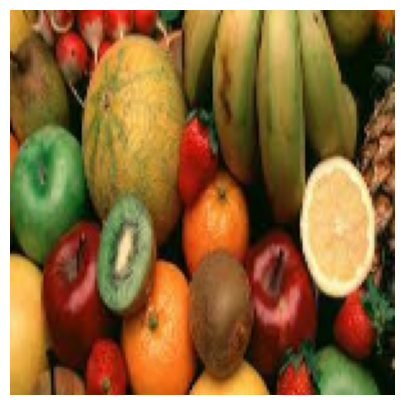

Saving photo_2023-06-28 12.49.43.jpeg to photo_2023-06-28 12.49.43.jpeg


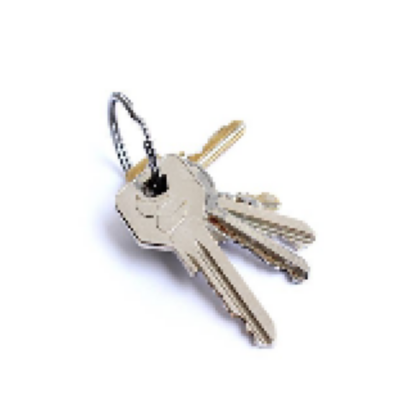

Saving 10cent_608.jpg to 10cent_608.jpg


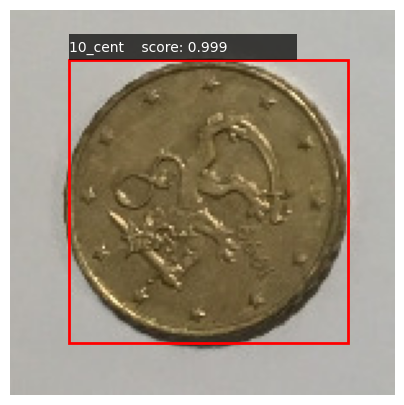

Saving 10cent_1109.jpg to 10cent_1109.jpg


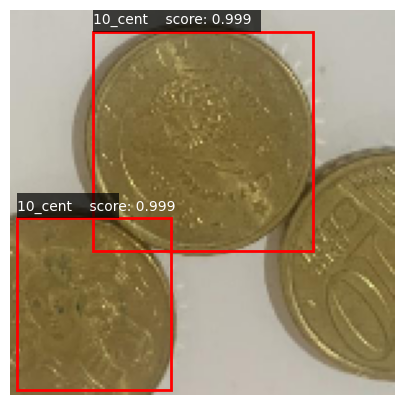

In [22]:
prove = input("Inserire numero di prove che si vogliono effettuare")
for i in range(int(prove)):
  # Upload dell'immagine
  uploaded = files.upload()

  # Lettrura dell'immagine
  image_path = next(iter(uploaded))
  image_bytes = uploaded[image_path]
  image_array = np.asarray(bytearray(image_bytes), dtype=np.uint8)
  image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

  # Conversione dell'immagine da BGR a RGB e infine in Float
  img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

  # Resize dell'immagine a 150 x 150 pixel, come richiesto dal modello
  resized_image = cv2.resize(img_rgb, (150, 150), cv2.INTER_AREA)

  # Normalizzazione dell'immagine
  resized_image /= 255.0

  img_res = resized_image
  # Caricamento del modello ONNX
  onnx_file = "/content/drive/MyDrive/Colab_Notebooks/Machine_Learning/Progetto/CheckPoint/faster_rcnn.onnx"
  model = onnx.load(onnx_file)
  # Creazione di una sessione runtime di ONNX
  session = onnxruntime.InferenceSession(onnx_file)

  # Esecuzione del modelo con immagini in input
  input_name = session.get_inputs()[0].name
  output_names = [output.name for output in session.get_outputs()]
  img_trs = np.expand_dims(img_res.transpose(2, 0, 1), axis=0)
  img_cuda = torch.from_numpy(img_trs).cuda()
  outputs = session.run(output_names, {input_name: img_cuda.cpu().numpy()})

  # Spacchettament dell'output del modello
  boxes, labels, scores = outputs

  # Conversione in tensori per la funzione di plot
  boxes_tensor = torch.tensor(boxes)
  labels_tensor = torch.tensor(labels)
  scores_tensor = torch.tensor(scores)
  predict = {'boxes': boxes_tensor, 'labels': labels_tensor, 'scores': scores_tensor}
  img_final= np.transpose(image, (2,0,1))
  img_final = (img_res*255).astype(np.uint8)
  # Seleziona solo le bounding-boxe con IoU score accettabile
  nms_prediction = apply_nms(predict)
  plot_img_bbox2(torch_to_pil(img_final), nms_prediction)